In [15]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time
from datetime import datetime
import numpy as np
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

### <mark> Look at the data </mark>

In [16]:
train = pd.read_csv("data/train.csv")
display(train.head())
display(train.describe())
print(f"Total number of Country/Region affected is {train['Country/Region'].nunique()}")
print(f"Earlies date is {max(train['Date'])}, and latest date is {min(train['Date'])}")

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


,Id,Lat,Long,ConfirmedCases,Fatalities
count,16756.000000,16697.000000,16697.000000,16756.000000,16756.000000
mean,13189.500000,26.337324,5.039603,271.750119,9.221533
std,7624.686932,22.963063,79.935267,3261.152305,141.524582
min,1.000000,-41.454500,-157.498300,0.000000,0.000000
25%,6595.250000,13.193900,-71.530100,0.000000,0.000000
50%,13189.500000,33.000000,10.000000,0.000000,0.000000
75%,19783.750000,42.506300,65.000000,7.000000,0.000000
max,26378.000000,72.000000,174.886000,67800.000000,4032.000000


Total number of Country/Region affected is 163
Earlies date is 2020-03-20, and latest date is 2020-01-22


In [17]:
data_4 = train[train["Country/Region"].isin(["China", "US", "Italy", "Spain"])]
data_4_date = data_4.groupby(["Date", 'Country/Region']).sum().reset_index()
data_4_date["Date"] = pd.to_datetime(data_4_date["Date"])
display(data_4_date.head(5))

,Date,Country/Region,Id,Lat,Long,ConfirmedCases,Fatalities
0,2020-01-22,China,193380,1083.3367,3684.4197,548.0,17.0
1,2020-01-22,Italy,12370,43.0000,12.0000,0.0,0.0
2,2020-01-22,Spain,18508,40.0000,-4.0000,0.0,0.0
3,2020-01-22,US,1308103,2190.7367,-4890.7490,0.0,0.0
4,2020-01-23,China,193413,1083.3367,3684.4197,643.0,18.0


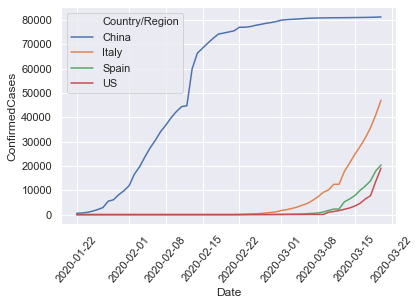

In [18]:
c = sns.lineplot(x='Date', y='ConfirmedCases', hue='Country/Region', data=data_4_date)
c.xaxis.set_tick_params(rotation=50)

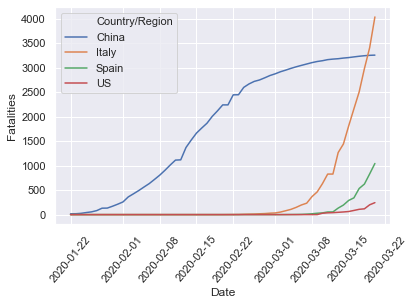

In [19]:
c = sns.lineplot(x='Date', y='Fatalities', hue='Country/Region', data=data_4_date)
c.xaxis.set_tick_params(rotation=50)

### <mark>SIR model initial flavor</mark>

In [20]:
# SIR model
# S = Suspected, I = Infected, R = Recovered

def dS(beta, S, I, N):
    return (-beta*S*I/N)

def dI(beta, gamma, S, I, N):
    return (beta*S*I/N - gamma*I)

def dR(gamma, I):
    return (gamma*I)


In [21]:
N = 1*(10**6)
days = 100

I = 1
S = N - I
R = 0
def cal_SIR(S, I, R, days, N, beta=1, gamma=0.1, ):
    SIR = [[0, 'suspected', S/N], [0, 'infected', I/N], [0, 'recovered', R/N]]
    for i in range(1, days+1):
        delta_S = dS(beta, S, I, N)
        delta_I = dI(beta, gamma, S, I, N)
        delta_R = dR(gamma, I)
        S += delta_S
        I += delta_I
        R += delta_R
        SIR.extend([[i, 'suspected', S/N], [i, 'infected', I/N], [i, 'recovered', R/N]])
    return SIR

Text(0.5, 1.0, 'When beta is 1, and gamma is 0.1')

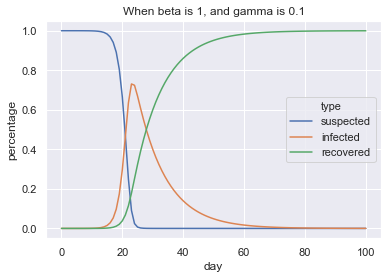

In [22]:
beta = 1
gamma = 0.1
SIR_1 = cal_SIR(S, I, R, days, N, beta, gamma)
df_sir_1 = pd.DataFrame(SIR_1, columns=['day', 'type', 'percentage'])

a = sns.lineplot(x='day', y='percentage', hue='type', data=df_sir_1)
a.set_title(f'When beta is {beta}, and gamma is {gamma}')  

Let's decrease the number of people we contact each day!


Text(0.5, 1.0, 'When beta is 0.5, and gamma is 0.1')

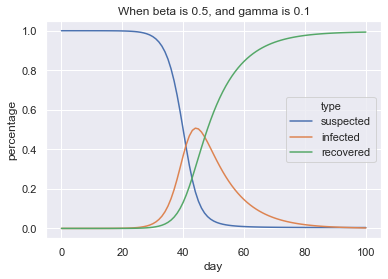

In [23]:
print("Let's decrease the number of people we contact each day!")
beta = 0.5
gamma = 0.1
SIR_2 = cal_SIR(S, I, R, days, N, beta, gamma)
df_sir_2 = pd.DataFrame(SIR_2, columns=['day', 'type', 'percentage'])

b = sns.lineplot(x='day', y='percentage', hue='type', data=df_sir_2)
b.set_title(f'When beta is {beta}, and gamma is {gamma}') 

### <mark>Model for Italy </mark>

In [24]:
data_italy = train[train["Country/Region"].isin(["Italy"])]
data_italy_date = data_italy.groupby(["Date", 'Country/Region']).sum().reset_index()
data_italy_date["Date"] = pd.to_datetime(data_4_date["Date"])
display(data_italy_date.head(2))
display(data_italy_date.tail(2))

,Date,Country/Region,Id,Lat,Long,ConfirmedCases,Fatalities
0,2020-01-22,Italy,12370,43.0,12.0,0.0,0.0
1,2020-01-22,Italy,12371,43.0,12.0,0.0,0.0


,Date,Country/Region,Id,Lat,Long,ConfirmedCases,Fatalities
57,2020-02-05,Italy,12427,43.0,12.0,41035.0,3405.0
58,2020-02-05,Italy,12428,43.0,12.0,47021.0,4032.0


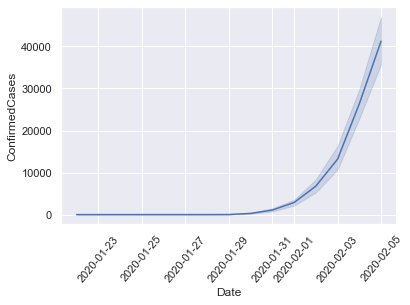

In [25]:
c = sns.lineplot(x='Date', y='ConfirmedCases',  data=data_italy_date)
c.xaxis.set_tick_params(rotation=50)


In [26]:
population_italy = 60486683
data_italy_date = data_italy_date[9:] # delete those zero
data_italy_date['day_count'] = list(range(1, len(data_italy_date)+1))

y = [i for i in data_italy_date.ConfirmedCases]
x = data_italy_date.day_count

y = np.array(y, dtype=float)
x = np.array(x, dtype=float)


In [27]:
N = population_italy
inf0 = y[0]
sus0 = N - inf0
rec0 = 0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, x, y)
fitted = fit_odeint(x, *popt)
    

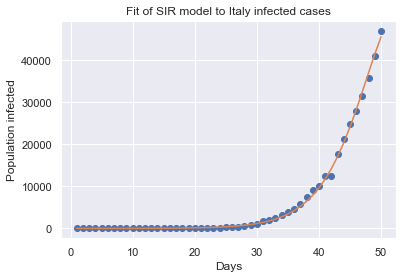

Optimal parameters: beta = 5.265555891446922  and gamma =  5.045574952742414


In [28]:
plt.plot(x, y, 'o')
plt.plot(x, fitted)
plt.title("Fit of SIR model to Italy infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
